### Imports

In [1]:
!pip install tensorflow==1.14.0
!pip install stable-baselines[mpi]==2.10.0
!pip install gym-anytrading
!pip install QuantStats

     |████████████████████████████████| 109.3 MB 45 kB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 488 kB 60.2 MB/s 
     |████████████████████████████████| 3.1 MB 72.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you

#Imports Part

In [7]:
import numpy as np
import pandas as pd

import gym
import gym_anytrading
import quantstats as qs

from stable_baselines import A2C
from stable_baselines.common.vec_env import DummyVecEnv

import matplotlib.pyplot as plt

**!!! QuantStats Python library that performs portfolio profiling, allowing quants and portfolio managers to understand their performance better by providing them with in-depth analytics and risk metrics.**

### Create Env
Environemnt Customized throught Stocks Google dataset. All other metrics are default.


In [8]:

df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

window_size = 10
start_index = window_size
end_index = len(df)

env_maker = lambda: gym.make(
    'stocks-v0',
    df = df,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env = DummyVecEnv([env_maker])

### Train Env
For train part multilayer perceptron (MLP) LSTM kullanılmıştır. 

In [9]:
policy_kwargs = dict(net_arch=[64, 'lstm', dict(vf=[128, 128, 128], pi=[64, 64])])
model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
model.learn(total_timesteps=1000)

---------------------------------
| explained_variance | -0.00676 |
| fps                | 12       |
| nupdates           | 1        |
| policy_entropy     | 0.678    |
| total_timesteps    | 5        |
| value_loss         | 6.48     |
---------------------------------
---------------------------------
| explained_variance | -0.00014 |
| fps                | 277      |
| nupdates           | 100      |
| policy_entropy     | 0.685    |
| total_timesteps    | 500      |
| value_loss         | 7.35     |
---------------------------------
---------------------------------
| explained_variance | 0.023    |
| fps                | 314      |
| nupdates           | 200      |
| policy_entropy     | 0.675    |
| total_timesteps    | 1000     |
| value_loss         | 0.443    |
---------------------------------


### Test Env

In [10]:
env = env_maker()
observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]

    # action = env.action_space.sample()
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': 531.0542959999982, 'total_profit': 0.000265655023672628, 'position': 1}


### Plot Results

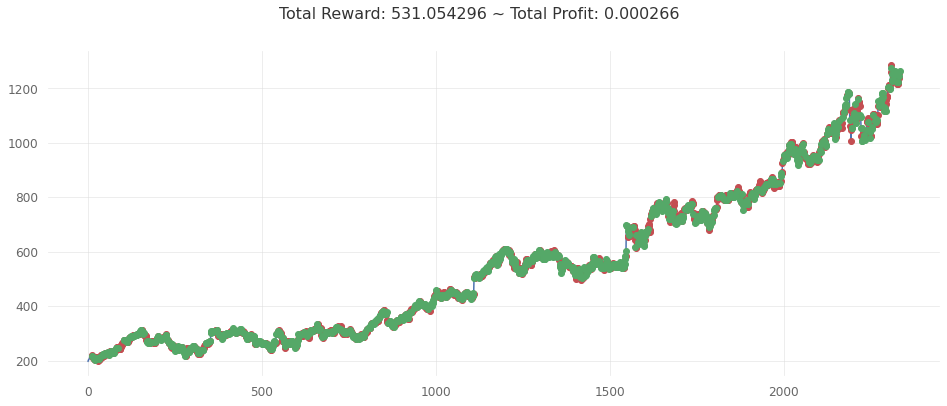

In [11]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

### Analysis Using `quantstats`

[Performance Metrics]



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


                           Strategy
-------------------------  ----------
Start Period               2009-06-10
End Period                 2018-08-29
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -99.97%
CAGR%                      -59.04%

Sharpe                     -4.83
Sortino                    -5.1
Sortino/√2                 -3.6

Max Drawdown               -99.97%
Longest DD Days            3365
Volatility (ann.)          18.1%
Calmar                     -0.59
Skew                       -0.85
Kurtosis                   24.96

Expected Daily %           -0.35%
Expected Monthly %         -7.15%
Expected Yearly %          -56.1%
Kelly Criterion            -91.54%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.22%
Expected Shortfall (cVaR)  -2.22%

Gain/Pain Ratio            -0.87
Gain/Pain (1M)             -0.99

Payoff Ratio               0.82
Profit Factor              0.13
Common Sense Ratio         0.0
CPC Index      

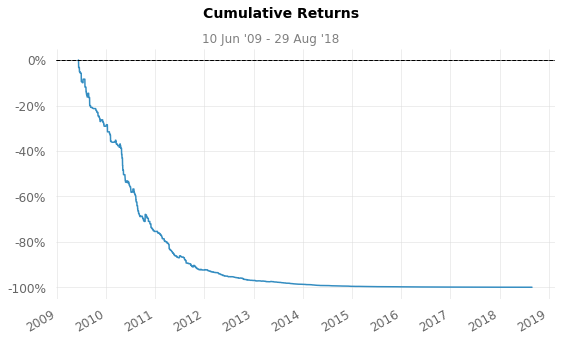

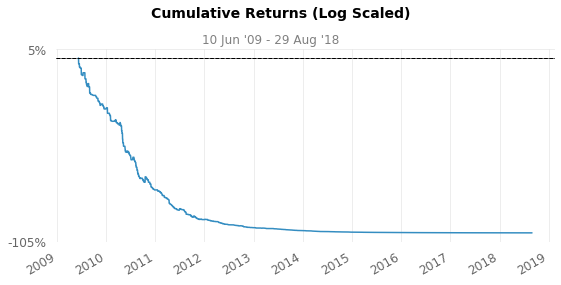

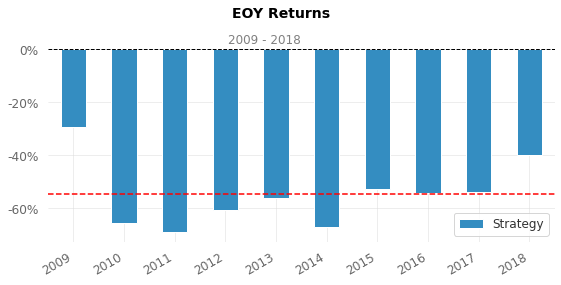

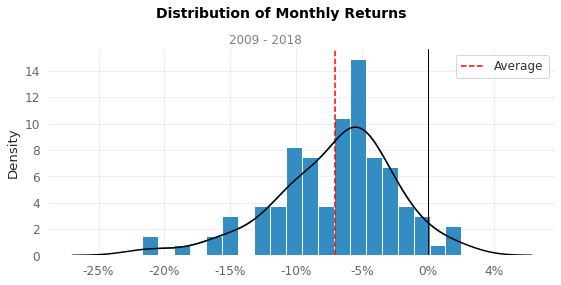

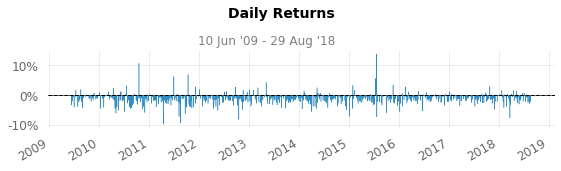

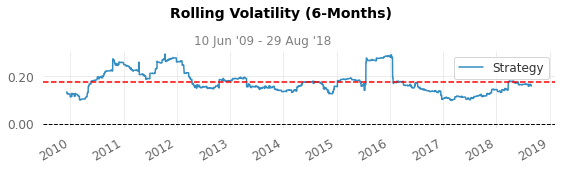

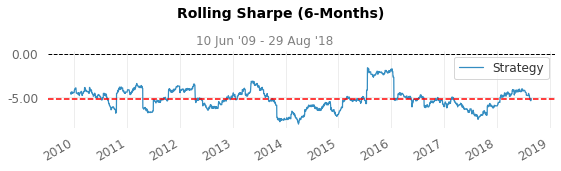

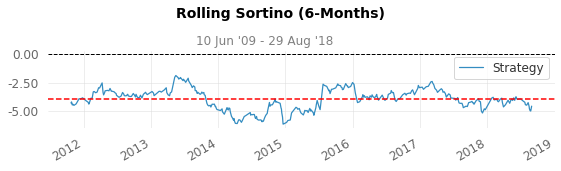

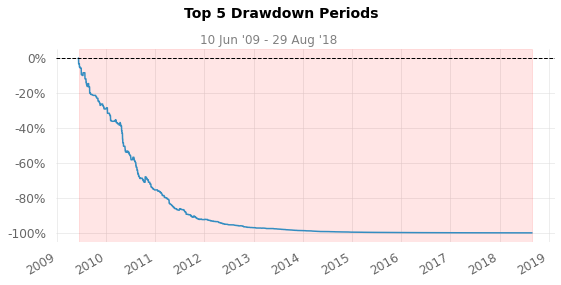

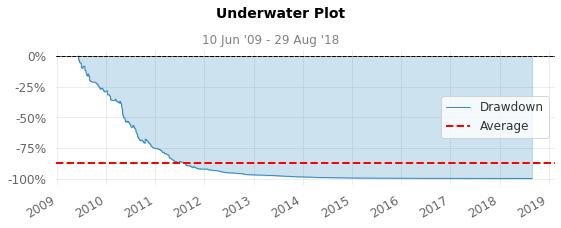

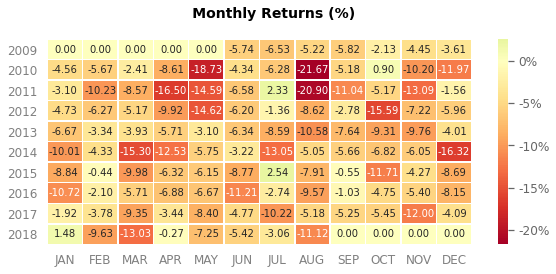

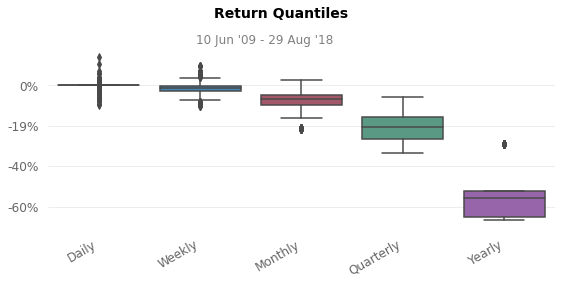

In [12]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='a2c_quantstats.html')